In [1]:
## Loading Libraries
import pandas as pd
import numpy as np
import networkx as nx
from random import uniform
import random
import pickle
import pytz
import winsound
from copy import deepcopy
from scipy.stats import spearmanr


# import power_index_calculator as px
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from generateRandSeed import generateRandSeed
from plot_simulation_output import plot_simulation_output
from Simulate_SIR_Time import Simulate_SIR_Time
from TransmissionGraph import TransmissionGraph
from tell_time import tell_time

## Loading Graphs

In [3]:
path=r'C:\Users\Mahdi\OneDrive\Vasserman - Akbarpour\Data\ResultMultigraphs/'
with open(path+"GraphList_Multi", 'rb') as fp:
    GraphList = pickle.load(fp) 

In [4]:
# Graph Size
Size = []
for G in GraphList:
    Size.append(G.number_of_nodes())

Graph_size_dict = {k:v for k,v in zip(list(range(len(GraphList))),Size)}
Graph_size_dict = {k: v for k, v in sorted(Graph_size_dict.items(), key=lambda item: item[1],reverse=True)}
list(Graph_size_dict.items())[2]

(49, 327)

# Run Your Simulation

In the below example, we create an Erdos-Renyi graph and we run the simulation and plot the outputs.

The Peak is 0.374, and the Cascade is 0.703, and Peak_int is 4


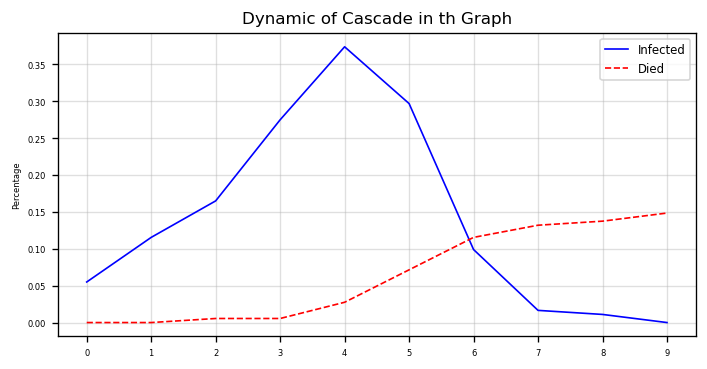

Wall time: 13.6 s


()

In [5]:
%%time
# Copying mulitigraph (Otherwise it's chnaged in the each run)
data = [deepcopy(x) for x in GraphList]
# Creating the graph with given P and filteration policy
Dict = {"Money":0.2,"Visit":0.2,"Kerosene":0.2,"Temple":0.2}
G_list = TransmissionGraph(Data=data,dropNode='',dropTop=0,Label_dict = Dict)
G = G_list[0]

out = Simulate_SIR_Time (deepcopy(G),Maximum_Time=1000,
                         Seasons=[50,100,150,200],P_seasons = [1,1,1,1],
                         Seeds = generateRandSeed(10,G), 
                         n_dr=1, q_die=0.2, n_exposed=0,q_symptotic=0, q_s=0.5,
                         how='Transmission',
                         time_policy={'mode':'stochastic','stochastic':{'p':1},
                        'deterministic':{'group_num':2,'method':'divide'}},pnt=False)

print('The Peak is {:0.3f}, and the Cascade is {:0.3f}, and Peak_int is {}'.format(
    out['Peak'],out['Cascade'],out['Peak_int']))
plot_simulation_output(Graphsize=G.number_of_nodes(),data = out,module=['Infected','Died'])

# **Simulation**

In [6]:
def find_Cascade_Lambda(G,number_seed,repeat):

    OUT = {'Cascade':list()}

    for i in range(repeat):
        out = Simulate_SIR_Time(deepcopy(G),Maximum_Time=1000,
                           Seasons=[50,100,150,200],P_seasons = [1,1,1,1],
                           Seeds = generateRandSeed(number_seed,G), 
                           n_dr=1, q_die=0.2, n_exposed=0,q_symptotic=0, q_s=1,
                           how='Transmission',
                           time_policy={'mode':'stochastic','stochastic':{'p':1},
                                        'deterministic':{'group_num':2,'method':'stochastic'}},pnt=False)
        
        OUT['Cascade'].append(out['Cascade'])


    w,v = np.linalg.eigh(nx.adjacency_matrix(G,weight=None).A)    
    Lambda=  np.round(max(w),4)
    w,v = np.linalg.eigh(nx.adjacency_matrix(G,weight='weight').A)    
    Lambda_weighted =  np.round(max(w),4)
    
    avg_deg = np.round(2*G.number_of_edges()/G.number_of_nodes(),3)
    
    out_des = pd.DataFrame(OUT).describe()
    
    out = {'Cascade':np.round(out_des.loc['mean','Cascade'],4),'lambda':Lambda,'lambda_weighted':Lambda_weighted,
           'Average_degree':avg_deg}

    return(out)

In [7]:
def Policy_lambda_cascade_table(i,repeat,number_seed,P={'m':0.2,'v':0.3,'k':0.25,'t':0.5},
                               Policy={'No Policy':{},'Ban Money':{'m':0}},pnt=False):
    res = []
    res_ind = []

    m,v,k,t=P['m'],P['v'],P['k'],P['t']
    local_dic = {'m':'Money','v':'Visit','k':'Kerosene','t':'Temple'}
    
    for policy,dic in Policy.items():
        if pnt:
            tell_time(msg='\n'+policy+' has started!')
        
        Dict = {'Money':m,'Visit':v,'Kerosene':k,'Temple':t}
        for key,value in dic.items():
            Dict[local_dic[key]] = value
        
        data = [deepcopy(x) for x in GraphList[i:(i+1)]]
        G_list = TransmissionGraph(Data=data[0:1],dropNode='',dropTop=0,Label_dict = Dict)
        G = G_list[0]
        
        out = find_Cascade_Lambda(deepcopy(G),number_seed=number_seed,repeat=repeat)
        res_ind.append(policy)
        res.append(out)
    
    
    # Printing Results
    Results = pd.DataFrame(res,index=res_ind)
    
    Results['avg_deg_rank'] = Results['Average_degree'].rank(method='min')
    
    Results['d_Cas'] = Results['Cascade'] - Results.loc['No Policy','Cascade']
    Results['d_Cas_rank'] = Results['d_Cas'].rank(method='min')

    Results['d_lam'] = Results['lambda'] - Results.loc['No Policy','lambda']
    Results['d_lam_rank'] = Results['d_lam'].rank(method='min')

    Results['d_lam_wei'] = Results['lambda_weighted'] - Results.loc['No Policy','lambda_weighted']
    Results['d_lam_wei_rank'] = Results['d_lam_wei'].rank(method='min')
    
    if pnt:
        tell_time(msg='**End**')
        
    return(Results)

In [12]:
%%time
Policy={'No Policy':{},'Ban Money':{'m':0},'Ban Visit':{'v':0},'Ban Kerosene':{'k':0},'Ban Temple':{'t':0},
        'Ban Money and Visit':{'m':0,'v':0},'Ban Temple and Visit':{'t':0,'v':0},
        'Ban Money and Kerosene':{'m':0,'k':0},'Ban Kerosene and Visit':{'k':0,'v':0},
        'Ban Kerosene and Temple':{'k':0,'t':0},'
        Ban Money and Visit and Kerosene':{'m':0,'v':0,'k':0}}
temp = Policy_lambda_cascade_table(i=34,repeat=200,number_seed=10,P={'m':0.3,'v':0.3,'k':0.3,'t':0.3},
                                   Policy = Policy,pnt=False)
temp

Wall time: 1min 6s


## Finding Correlation

In [20]:
def FindCorrelation(V_Repeat,repeat):
    
    ####################     Initilizing    #########################
    sym = {'cascade_weighted_lambda':list(),'P_cwl':list(),'cascade_average_degree':list(),
           'P_cad':list(),'cascade_lambda':list(),'P_cl':list()}
    
    Asym = {'cascade_weighted_lambda':list(),'P_cwl':list(),'cascade_average_degree':list(),
            'P_cad':list(),'cascade_lambda':list(),'P_cl':list()}
    
    Policy={'No Policy':{},'Ban Money':{'m':0},'Ban Visit':{'v':0},'Ban Kerosene':{'k':0},'Ban Temple':{'t':0},
            'Ban Money and Visit':{'m':0,'v':0},'Ban Temple and Visit':{'t':0,'v':0},'Ban Money and Kerosene':{'m':0,'k':0},
            'Ban Kerosene and Visit':{'k':0,'v':0},'Ban Kerosene and Temple':{'k':0,'t':0},'Ban Money and Visit and Kerosene':{'m':0,'v':0,'k':0}}
    
    
    
    for cnt in range(V_Repeat):
        if cnt%5==0:
            tell_time(str(cnt+1)+' from '+str(V_Repeat))
        
        i = random.randrange(0,len(GraphList))
        
        ####################     Symmetric    #########################
        sym_p = random.uniform(0.1,0.5)
        temp = Policy_lambda_cascade_table(i=i,repeat=repeat,number_seed=10,
                                    P={'m':sym_p,'v':sym_p,'k':sym_p,'t':sym_p},Policy = Policy)
        
        cor,p = spearmanr(temp['Cascade'],temp['lambda_weighted'])
        sym['cascade_weighted_lambda'].append(cor)
        sym['P_cwl'].append(p)
        
        cor,p = spearmanr(temp['Cascade'],temp['Average_degree'])
        sym['cascade_average_degree'].append(cor)
        sym['P_cad'].append(p)
        
        cor,p = spearmanr(temp['Cascade'],temp['lambda'])
        sym['cascade_lambda'].append(cor)
        sym['P_cl'].append(p)
        
        
        ####################     Asymmetric    #########################
        temp = Policy_lambda_cascade_table(i=i,repeat=repeat,number_seed=10,
                                    P={'m':random.uniform(0.1,0.5),'v':random.uniform(0.1,0.5),
                                       'k':random.uniform(0.1,0.5),'t':random.uniform(0.1,0.5)},Policy = Policy)
        
        cor,p = spearmanr(temp['Cascade'],temp['lambda_weighted'])
        Asym['cascade_weighted_lambda'].append(cor)
        Asym['P_cwl'].append(p)
        
        cor,p = spearmanr(temp['Cascade'],temp['Average_degree'])
        Asym['cascade_average_degree'].append(cor)
        Asym['P_cad'].append(p)
        
        cor,p = spearmanr(temp['Cascade'],temp['lambda'])
        Asym['cascade_lambda'].append(cor)
        Asym['P_cl'].append(p)
        
    
    
    ####################     output    #########################
    SYM = pd.DataFrame(pd.DataFrame(sym).describe().loc['mean',]).rename(columns={'mean':'Symmetric'})
    ASYM = pd.DataFrame(pd.DataFrame(Asym).describe().loc['mean',]).rename(columns={'mean':'Asymmetric'})
    
    out = pd.merge(SYM,ASYM,left_index=True,right_index=True,how='outer')
    out.rename(index={'cascade_weighted_lambda':'Corr(cascade,weighted lambda)','P_cwl':'p_value',
                      'cascade_average_degree':'Corr(cascade,average degree)','P_cad':'p_value',
                      'cascade_lambda':'Corr(cascade,lambda)','P_cl':'p_value'},inplace=True)
    
    return(out)

In [ ]:
%%time
Ans = FindCorrelation(500,200)
Ans

1 from 500
Current time is:  18:56:20
6 from 500
Current time is:  19:15:55
11 from 500
Current time is:  19:31:34
16 from 500
Current time is:  19:44:01
21 from 500
Current time is:  20:04:40
26 from 500
Current time is:  20:23:10
31 from 500
Current time is:  20:39:08
36 from 500
Current time is:  20:54:19
41 from 500
Current time is:  21:12:31
46 from 500
Current time is:  21:35:17
51 from 500
Current time is:  21:49:15
56 from 500
Current time is:  22:10:28
61 from 500
Current time is:  22:24:53
66 from 500
Current time is:  22:42:48
71 from 500
Current time is:  22:56:23
76 from 500
Current time is:  23:14:43
81 from 500
Current time is:  23:31:58
86 from 500
Current time is:  23:49:38
91 from 500
Current time is:  00:05:00
96 from 500
Current time is:  00:19:58
101 from 500
Current time is:  00:39:45
106 from 500
Current time is:  00:56:51
111 from 500
Current time is:  01:17:20
116 from 500
Current time is:  01:34:05
121 from 500
Current time is:  01:53:54
126 from 500
Current t